# Nonlinear Dynamical System

In [1]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); Pkg.instantiate(); 

  Activating project at `~/.julia/dev/RxInfer/examples`


In this example the goal is to estimate hidden states of a Dynamical process where all hidden states are Gaussians. Our process can be described with the following equations:

$$\begin{aligned}
 p(\tau) & = \Gamma(\alpha_{1}, \beta_{1}),\\
 p(\theta) & = \Gamma(\alpha_{2}, \beta_{2}),\\
 p(z_i|z_{i - 1}) & = \mathcal{N}(x_i| z_{i - 1} + 1, \tau),\\
 p(y_i|z_i) & = \mathcal{N}(y_i|(z_i - s)^2, \theta),
\end{aligned}$$

where $z_i$ are hidden states, $y_i$ are noisy nonlinear observations, $\tau$, and $\theta$ are priors for state transition noise and observation noise precision, respectively.

To model this process in `RxInfer`, first, we start with importing all needed packages:

In [2]:
using RxInfer, Random, LinearAlgebra, Plots, Flux, ForwardDiff, Plots, StableRNGs

┌ Info: Precompiling RxInfer [86711068-29c9-4ff7-b620-ae75d7495b3d]
└ @ Base loading.jl:1664


Next step, is to generate some synthetic data:

In [3]:
seed = 123

rng = MersenneTwister(seed)

P = 5
sensor_var = 5

T = 50

sensor_location = 53

hidden = collect(1:T)
data   = (hidden + rand(rng, NormalMeanVariance(0.0, sqrt(P)), T));
transformed = (data .- sensor_location).^2 + rand(rng, NormalMeanVariance(0.0, sensor_var), T);

Let's plot our synthetic dataset. 
The blue line represents our hidden state we want to estimate using noisy observations, 
which are represented as dots.

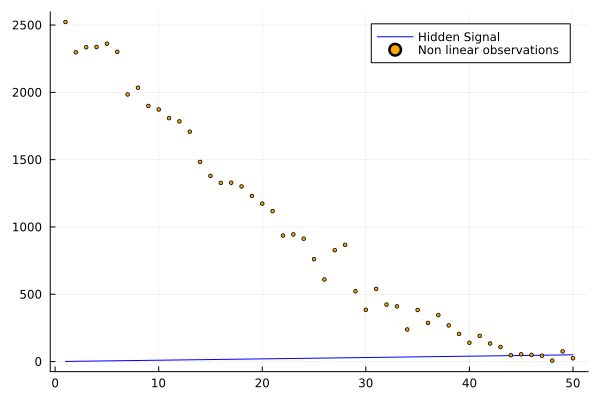

In [4]:
px = plot()

px = plot!(px, hidden, label = "Hidden Signal", color = :blue)
px = scatter!(px, transformed, label = "Non linear observations", markersize = 2, color = :orange)

plot(px)

To create a model we use `GraphPPL` package and `@model` macro:

In [5]:
function f(z)
    (z - sensor_location)^2
end

@model function sensor_based_observation(T, rng, n_iterations, n_samples, learning_rate)

    z = randomvar(T)
    x = randomvar(T)
    y = datavar(Float64, T)

    τ ~ GammaShapeRate(1.0, 1.0e-12)
    θ ~ GammaShapeRate(1.0, 1.0e-12)
    
    z[1] ~ NormalMeanPrecision(0, τ)
    x[1] ~ f(z[1]) where {meta = CVIApproximation(rng, n_iterations, n_samples, Descent(learning_rate))}
    y[1] ~ NormalMeanPrecision(x[1], θ)

    for t in 2:T
        z[t] ~ NormalMeanPrecision(z[t-1] + 1, τ)
        x[t] ~ f(z[t]) where {meta = CVIApproximation(rng, n_iterations, n_samples, Descent(learning_rate))}
        y[t] ~ NormalMeanPrecision(x[t], θ)
    end

    return z, x, y
end

constraints = @constraints begin
    q(z, x, τ, θ) = q(z)q(x)q(τ)q(θ)
end;

To run inference we will use `inference` function from `ReactiveMP`.
Note, that for running inference for this model we need to init marginals for z, $\theta$, $\tau$, and init z messages.

In [6]:
res = inference(
    model = sensor_based_observation(T, StableRNG(42), 100, 200, 0.01),
    data = (y = transformed,),
    iterations = 5,
    free_energy = true,
    returnvars = (z = KeepLast(),),
    constraints = constraints,
    initmessages = (z = NormalMeanVariance(0, P),),
    initmarginals = (z = NormalMeanVariance(0, P), τ = GammaShapeRate(1.0, 1.0e-12), θ = GammaShapeRate(1.0, 1.0e-12),),
)

Inference results:
  Posteriors       | available for (z)
  Free Energy:     | Real[1244.73, 430.145, 377.663, 366.977, 364.112]


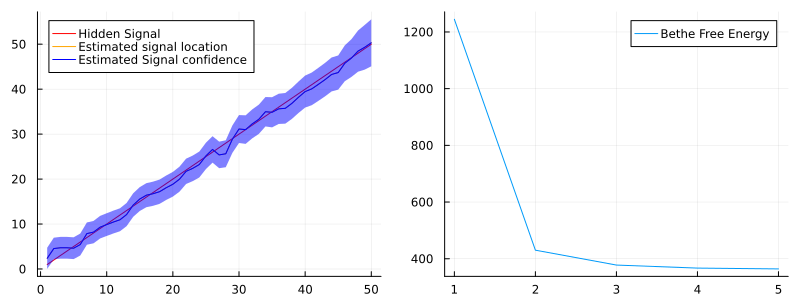

In [7]:
px = plot(legend = :topleft)

px = plot!(px,  hidden, label = "Hidden Signal", color = :red)
px = plot!(px,  map(mean, res.posteriors[:z]), label = "Estimated signal location", color = :orange)
px = plot!(px,  map(mean, res.posteriors[:z]), ribbon = std.(9 .* res.posteriors[:z]).|> sqrt, fillalpha = 0.5, label = "Estimated Signal confidence", color = :blue)

pf = plot()
pf = plot!(pf, res.free_energy, label = "Bethe Free Energy")

plot(px, pf, size = (800, 300))